# Project 4: Exploring the UK's milk imports and exports

by Tomahawk Jupiter, 14 January 2024

This is the project notebook for Part 4 of The Open University's _Learn to Code for Data Analysis_ course.

## Table of Contents

- [The Project](#the-project)
- [Getting and Preparing the Data](#getting-and-preparing-the-data)
- [Questions](#questions)
- [Extra Questions](#extra-questions)

## The Project

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the UK's imports and exports of two categories of milk products in 2014:

1. How much does the UK export and import and is the balance positive (more exports than imports)? 
2. Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?
3. Which are the regular customers, i.e. which countries buy milk from the UK every month?
4. Which countries does the UK both import from and export to?

Extra questions:

1. Which are the regular exporters, i.e. which countries sell every month both unprocessed and processed milk and cream to the UK?
1. Where could the export market be further developed, i.e. which countries import the least? Do the figures look realistic?

In [189]:
import pandas as pd
print(pd.__version__)
%matplotlib inline

1.4.4


## Getting and preparing the data

The data is obtained from the [United Nations Comtrade website](http://comtrade.un.org/data/) by selecting the following configuration (go to andvanced search page):

- type of Product: goods
- Frequency: monthly
- Period: 2014
- Reporter: United Kingdom
- Partners: all
- Flow: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

In [190]:
CSV_FILE = 'uk_milk_export_import.csv'
milk = pd.read_csv(CSV_FILE, encoding='ISO-8859-1', dtype={'CmdCode':str})
milk.head(1)

,TypeCode,FreqCode,RefPeriodId,RefYear,RefMonth,Period,ReporterCode,ReporterISO,ReporterDesc,FlowCode,...,IsNetWgtEstimated,GrossWgt,IsGrossWgtEstimated,Cifvalue,Fobvalue,PrimaryValue,LegacyEstimationFlag,IsReported,IsAggregate,Unnamed: 47
0,C,M,20140501,2014,5,201405,826,GBR,United Kingdom,M,...,False,0,False,2.166566e+07,0.0,2.166566e+07,0,False,True,NaN


### Select Columns

There are alot of columns I don't need. First I look at the columns so I can decide which ones to keep.

In [191]:
milk.columns

Index(['TypeCode', 'FreqCode', 'RefPeriodId', 'RefYear', 'RefMonth', 'Period',
       'ReporterCode', 'ReporterISO', 'ReporterDesc', 'FlowCode', 'FlowDesc',
       'PartnerCode', 'PartnerISO', 'PartnerDesc', 'Partner2Code',
       'Partner2ISO', 'Partner2Desc', 'ClassificationCode',
       'ClassificationSearchCode', 'IsOriginalClassification', 'CmdCode',
       'CmdDesc', 'AggrLevel', 'IsLeaf', 'CustomsCode', 'CustomsDesc',
       'MosCode', 'MotCode', 'MotDesc', 'QtyUnitCode', 'QtyUnitAbbr', 'Qty',
       'IsQtyEstimated', 'AltQtyUnitCode', 'AltQtyUnitAbbr', 'AtlQty',
       'IsAltQtyEstimated', 'NetWgt', 'IsNetWgtEstimated', 'GrossWgt',
       'IsGrossWgtEstimated', 'Cifvalue', 'Fobvalue', 'PrimaryValue',
       'LegacyEstimationFlag', 'IsReported', 'IsAggregate', 'Unnamed: 47'],
      dtype='object')

In [192]:
COLUMNS = ['RefMonth', 'FlowDesc', 'PartnerDesc', 'CmdCode', 'PrimaryValue']

milk = milk[COLUMNS]

### Rename Columns

In [193]:
milk = milk.rename(columns={'RefMonth':'Month Number', 'FlowDesc': 'Trade Flow', 'PartnerDesc': 'Partner', 'CmdCode': 'Commodity', 'PrimaryValue': 'Trade Value ($)'})
milk.head(1)

,Month Number,Trade Flow,Partner,Commodity,Trade Value ($)
0,5,Import,World,0401,2.166566e+07


I change the commodity code into a short text description and add a column for month names, this might be useful later.

In [194]:
def commodity_to_text(code):
  if code == '0401':
    return 'unprocessed'
  if code == '0402':
    return 'processed'
  return 'unknown'

def get_month_name(month_number):
  if 1 <= month_number <= 12:
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    return months[month_number - 1]
  else:
    return "Invalid"


COMMODITY = 'Commodity'
MONTH_NUMBER = 'Month Number'
MONTH_NAME = 'Month Name'
FLOW = 'Trade Flow'
PARTNER = 'Partner'
VALUE = 'Trade Value ($)'

milk[COMMODITY] = milk[COMMODITY].apply(commodity_to_text)
milk[MONTH_NAME] = milk[MONTH_NUMBER].apply(get_month_name)
milk.head(1)

,Month Number,Trade Flow,Partner,Commodity,Trade Value ($),Month Name
0,5,Import,World,unprocessed,2.166566e+07,May


### Keep only individual countries


In [195]:
milk = milk[milk[PARTNER] != 'World']

## Questions

### Q1. How much does the UK export and import and is the balance positive (more exports than imports)? 

I group by trade flow and aggregate by adding the Trade Values for each group. After doing this I see that Exports are higher than Imports, I then calculate the difference and format the result to make it easier to read.

In [196]:
flow_groups = milk.groupby(FLOW)[VALUE].agg(sum)
flow_groups

Trade Flow
Export    8.986520e+08
Import    5.638849e+08
Name: Trade Value ($), dtype: float64

In [197]:

difference = flow_groups.max() - flow_groups.min()
format_result = round(difference / 1_000_000)
print(f"There are ${format_result} million more exports than there are imports.")

There are $335 million more exports than there are imports.


### Q2. Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?

#### Combined imports and exports

I group by country and add all trade values together. I sort in descending order, this will put the top partners at the top.

In [198]:
partner_totals = milk.groupby(PARTNER)[VALUE].agg(sum)
num_of_partners = len(partner_totals)

print(f"The UK trades with {num_of_partners} countries.\nIt's top five trade partners are:")
partner_totals.sort_values(ascending=False)[:5]

The UK trades with 120 countries.
It's top five trade partners are:


Partner
Ireland        5.955443e+08
Netherlands    1.408583e+08
France         1.396312e+08
Germany        1.127093e+08
Algeria        9.375384e+07
Name: Trade Value ($), dtype: float64

#### Import and Export Breakdown

Then I seperate by Export and Import and do the same.

In [199]:

exports = milk[milk[FLOW] == 'Export']
imports = milk[milk[FLOW] == 'Import']

top_exports = exports.groupby(PARTNER)[VALUE].agg(sum).sort_values(ascending=False)
top_imports = imports.groupby(PARTNER)[VALUE].agg(sum).sort_values(ascending=False)

top_5_exports = top_exports[:5]
top_5_imports = top_imports[:5]

print(f"The UK exports to {len(top_exports)} countries. The top 5 are:\n")
print(top_5_exports, '\n')

print(f"The UK imports from {len(top_imports)} countries. The top 5 are:\n")
print(top_5_imports)


The UK exports to 120 countries. The top 5 are:

Partner
Ireland        4.212284e+08
Algeria        9.375384e+07
Netherlands    6.864908e+07
Germany        3.609663e+07
France         3.462298e+07
Name: Trade Value ($), dtype: float64 

The UK imports from 25 countries. The top 5 are:

Partner
Ireland        1.743159e+08
France         1.050082e+08
Germany        7.661270e+07
Netherlands    7.220923e+07
Belgium        5.833875e+07
Name: Trade Value ($), dtype: float64


I look at the overlap between top export and import partners. All but one country is in both top fives, though in different orders. 

             Trade Value ($): Exports  Trade Value ($): Imports
Partner                                                        
France                   3.462298e+07              1.050082e+08
Germany                  3.609663e+07              7.661270e+07
Ireland                  4.212284e+08              1.743159e+08
Netherlands              6.864908e+07              7.220923e+07


Text(0.5, 1.0, 'Countries that are in top 5 for either Exports OR Imports')

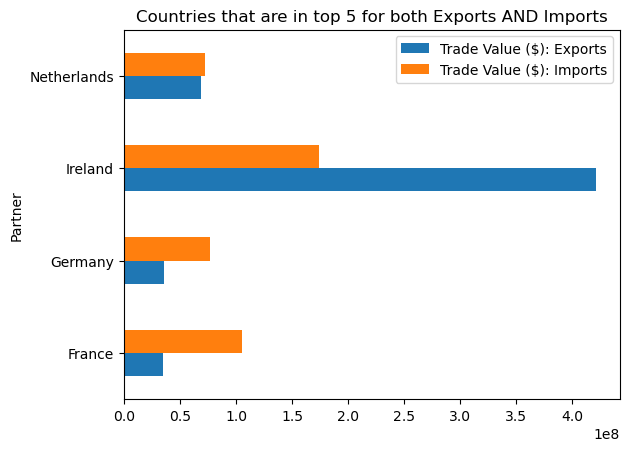

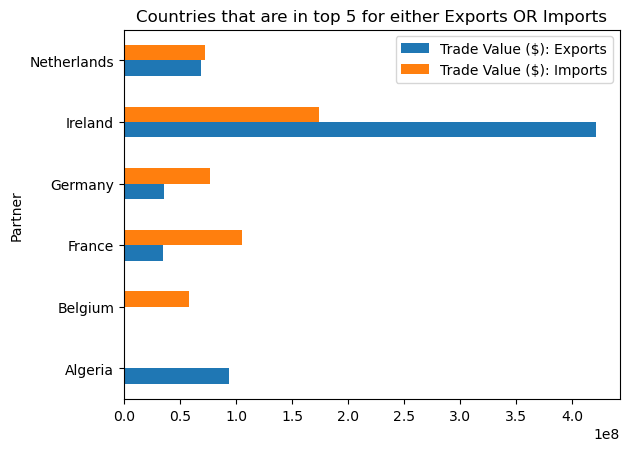

In [200]:
appears_in_both = pd.merge(top_5_exports, top_5_imports, on=PARTNER, how='inner', suffixes=(': Exports', ': Imports')).sort_index()
print(appears_in_both)
appears_in_both.plot(kind='barh').set_title('Countries that are in top 5 for both Exports AND Imports')

combined = pd.merge(top_5_exports, top_5_imports, on=PARTNER, how='outer', suffixes=(': Exports', ': Imports')).sort_index()
combined.plot(kind='barh').set_title('Countries that are in top 5 for either Exports OR Imports')



### Q3. Which are the regular customers, i.e. which countries buy milk from the UK every month?

First I broke it down by processed and unprocessed, then both together.

In [201]:
def imports_every_month(group):
  return len(group) == 12

# imports.groupby(PARTNER).filter(imports_every_month)
imports_unprocessed = exports[exports[COMMODITY] == 'unprocessed']
imports_processed = exports[exports[COMMODITY] == 'processed']

imports_processed_every_month = imports_processed.groupby(PARTNER).filter(imports_every_month)
imports_unprocessed_every_month = imports_unprocessed.groupby(PARTNER).filter(imports_every_month)

imports_processed_every_month_group = imports_processed_every_month.groupby(PARTNER)[VALUE].agg(['size', sum]).sort_values('sum', ascending=False).rename(columns={'size':'Months Traded', 'sum': 'Total Trade ($)'})
imports_unprocessed_every_month_group = imports_unprocessed_every_month.groupby(PARTNER)[VALUE].agg(['size', sum]).sort_values('sum', ascending=False).rename(columns={'size':'Months Traded', 'sum': 'Total Trade ($)'})

print(f"There are {len(imports_processed_every_month_group)} countries that import 'PROCESSED' milk every month. The top 5 are:\n")
print(imports_processed_every_month_group[:5], '\n')

print(f"There are {len(imports_unprocessed_every_month_group)} countries that import 'UNPROCESSED' milk every month. The top 5 are:\n")
print(imports_unprocessed_every_month_group[:5])


There are 24 countries that import 'PROCESSED' milk every month. The top 5 are:

                      Months Traded  Total Trade ($)
Partner                                             
Ireland                          12     9.488987e+07
Algeria                          12     9.375384e+07
Netherlands                      12     4.751867e+07
Germany                          12     2.478568e+07
China, Hong Kong SAR             12     1.552436e+07 

There are 16 countries that import 'UNPROCESSED' milk every month. The top 5 are:

             Months Traded  Total Trade ($)
Partner                                    
Ireland                 12     3.263386e+08
France                  12     2.559754e+07
Belgium                 12     2.304178e+07
Netherlands             12     2.113041e+07
China                   12     1.180622e+07


In [202]:
import_both_every_month = pd.concat([imports_unprocessed_every_month, imports_processed_every_month])
# import_both_every_month.groupby(PARTNER).size().apply(lambda x: x == 24)

def both_all(g):
  return len(g) == 24

import_both_every_month_group = import_both_every_month.groupby(PARTNER).filter(both_all).groupby(PARTNER)[VALUE].agg(['size', sum])

print(f"There are {len(import_both_every_month_group)} countries that import both processed and unprocessed milk every month. The top 5 are:\n")
import_both_every_month_group.sort_values('sum', ascending=False)[:5]



There are 14 countries that import both processed and unprocessed milk every month. The top 5 are:



,size,sum
Partner,,
Ireland,24,4.212284e+08
Netherlands,24,6.864908e+07
Germany,24,3.609663e+07
France,24,3.462298e+07
Belgium,24,2.934301e+07


In [203]:
regular_importer_percentage_of_total = (import_both_every_month_group['sum'].sum() / exports[VALUE].sum()) * 100

print(f"Regular importers account for {round(regular_importer_percentage_of_total, 2)}% of total UK exports.")

Regular importers account for 71.75% of total UK exports.


### Q4. Which countries does the UK both import from and export to?

I use a pivot table and drop na, this will remove rows that don't have both an import and export value. Including margins when creating the pivot table will add up the values in the rows and columns, adding a new row and a column for the totals. I drop the row margin because that adds all the rows together and what I want is the total for the columns.

In [204]:
countries_pivot = pd.pivot_table(
  milk,
  index=PARTNER,
  columns=[FLOW],
  values=VALUE,
  aggfunc=sum,
  margins=True,
  margins_name='Total'
)

countries_pivot = countries_pivot.dropna().drop('Total')
export_and_import_countries = countries_pivot.sort_values('Total', ascending=False)

print(f"There are {len(export_and_import_countries)} countries that the UK imports and exports with. The top 10 are:")
export_and_import_countries



There are 25 countries that the UK imports and exports with. The top 10 are:


Trade Flow,Export,Import,Total
Partner,,,
Ireland,4.212284e+08,1.743159e+08,5.955443e+08
Netherlands,6.864908e+07,7.220923e+07,1.408583e+08
France,3.462298e+07,1.050082e+08,1.396312e+08
Germany,3.609663e+07,7.661270e+07,1.127093e+08
Belgium,2.934301e+07,5.833875e+07,8.768176e+07
Denmark,2.908456e+06,3.053465e+07,3.344310e+07
Spain,3.548530e+06,1.691955e+07,2.046808e+07
Poland,1.596375e+06,1.495991e+07,1.655629e+07
Sweden,9.153971e+04,6.376717e+06,6.468257e+06


## Extra Questions

### Q1. Which are the regular exporters, i.e. which countries sell every month both unprocessed and processed milk and cream to the UK? 

In [205]:
def every_month(g):
  return len(g) == 24

exports_to_uk_every_month = imports.groupby(PARTNER).filter(every_month)

print('Countries that export both commodities to UK every month:')
exports_to_uk_every_month.groupby(PARTNER)[VALUE].agg([sum, 'size']).sort_values('sum', ascending=False)


Countries that export both commodities to UK every month:


,sum,size
Partner,,
Ireland,1.743159e+08,24
France,1.050082e+08,24
Germany,7.661270e+07,24
Netherlands,7.220923e+07,24
Belgium,5.833875e+07,24
Poland,1.495991e+07,24
Italy,2.300834e+06,24
Lithuania,5.776576e+05,24


### Q2. Where could the export market be further developed, i.e. which countries import the least? Do the figures look realistic?

I find the countries in the lower decile for importing from the UK, perhaps there is room for expanding exports to these countries. Some of the values look suspiciously low, eg. Slovenia $11.41.

In [233]:
export_group = exports.groupby(PARTNER)[VALUE].agg([sum]).sort_values('sum')

mean_exports = round(export_group.mean()['sum'])
median_exports = round(export_group.median()['sum'])
lower_decile = round(export_group.quantile(0.1)['sum'])

export_group['sum'] = export_group['sum'].apply(lambda x: float(f'{x:.2f}'))

lower_decile_countries = export_group[export_group['sum'] < lower_decile]

print(f"The mean for exports is ${mean_exports}.\nThe median is ${median_exports}.\nThe lower decile is ${lower_decile}.\n")

print("Bottom 10% of importers")
lower_decile_countries


The mean for exports is $7488766.
The median is $364597.
The lower decile is $8216.

Bottom 10% of importers


,sum
Partner,
Slovenia,11.41
Latvia,224.63
Croatia,315.71
Bulgaria,326.66
Slovakia,412.09
Lithuania,2012.71
Estonia,2420.81
Ukraine,2586.58
Israel,2744.22


## Conclusions

The UK exports to many more countries than it imports from (120 vs 25) and total exports are $335 million higher than imports. The top 14 countries it exports to regularly (both commodities every month) account for 71.75% of its exports.

Ireland is the partner that the UK trades most with by quite a large margin. France, Netherlands and Germany are also good trade partners.